In [1]:
# Set up 

# 1) In Terminal: 
#     - Create Virtual Environment: ` python3 -m venv deepracer_env` 
#     - Activate venv: `source deepracer_env/bin/activate`
#     - Install dependencies: `pip install shapely matplotlib pandas sklearn boto3 awscli sklearn`
# 
#
# Note: If you get an error like 
#
#       "ContextualVersionConflict: (s3transfer 0.3.3 (/usr/local/lib/python3.7/site-packages), 
#        Requirement.parse('s3transfer<0.2.0,>=0.1.10'), {'boto3'})# 
#
#        Check the fix out here: https://github.com/awslabs/aws-shell/issues/153 
#
#
# 2) Create IAM User and generate Access Key under 'Security Credentials': 
#      - Link to instructions: https://docs.aws.amazon.com/IAM/latest/UserGuide/getting-started_create-admin-group.html 
#      - I used 'administrator' and 'AWSDeepRacerServiceRole' policies
# 
#               
# 3) In Terminal:
#     - Enter `aws configure` followed by Access Key and Secret
#     - Specify JSON output and region

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
import os
import pprint
%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

from log_analysis import *
import cw_utils
import shutil

In [3]:
# Find your TRAINING Simulation Application ID for your model
stream_name = 'sim-2w3399l9mlmd' ## CHANGE 

# Download logs into log directory
fname = 'logs/deepracer-%s.log' %stream_name
cw_utils.download_log(fname, stream_prefix=stream_name)

In [9]:
# check to see if log was downloaded
!ls logs

deepracer-eval-sim-sample.log  deepracer-sim-nmj46v9ntn73.log
deepracer-sim-2w3399l9mlmd.log deepracer-sim-sample.log
deepracer-sim-3x86dg7vwlvq.log


## Load waypoints for the track you want to run analysis on

```
Tracks Available::
AWS_track                Straight_track                Oval_track
Bowtie_track             H_track                       reinvent_base

**Newly Added**

Virtual_May19_Train_track
London_Loop_Train
Canada_Training
Mexico_track
China_track
New_York_Track
Tokyo_Training
reInvent2019_track
ChampionshipCup2019_track
Vegas_track == 'AWS Summit Raceway'

```

In [18]:
# Load Track you used for Training

def get_track_waypoints(track_name):
    return np.load("tracks2/%s.npy" % track_name)
    
waypoints = get_track_waypoints("Vegas_track") ### re:invent track
waypoints.shape

(151, 6)

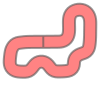

In [19]:
# Preview Track 

l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

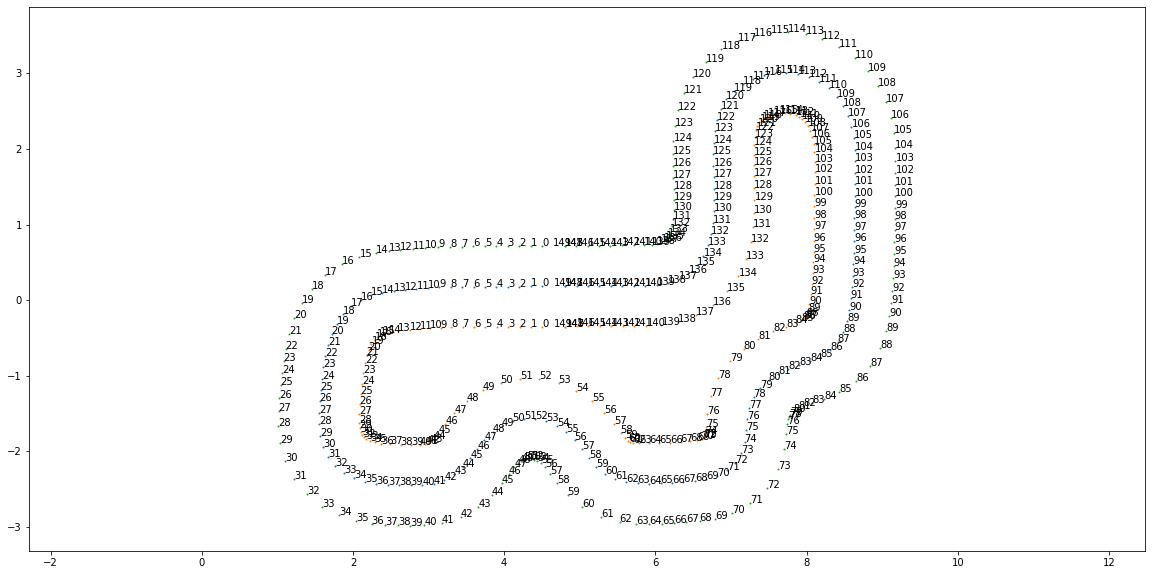

In [22]:
# Plot the the track 

def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1],s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0],p[1]))

fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

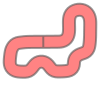

In [48]:
# IS THIS NECESSARY??
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

# Helper Functions 
Note: Be cognizant of the track size!

In [131]:


def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"] + x_offset)
        y = int(row["y"] + y_offset)
        reward = row["reward"]
        track[y, x] = reward
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return track

In [191]:
def plot_top_laps(sorted_idx, n_laps=5):
    
    y_offset = int(df['y'].min())
    
    if y_offset > 0: # if positive, just keep it the same
        y_offset = 0
        y_offset = abs(y_offset)
    
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [(y1*100) - y_offset, (car_y2*100) - y_offset], '.b')
        
    return fig

# Load Training Log

In [28]:
# Update log_name to appropriate Simulation Application ID

log_name = 'logs/deepracer-sim-2w3399l9mlmd.log'
data = load_data(log_name)

print('Previewing Data: {} observations'.format(len(data)))
print(data[:1])

Previewing Data: 18726 observations
['0,1,4.3635,0.1809,-179.7030,30.00,0.67,12,0.0000,False,True,0.6196,1,22.55,1589482138.3998744,in_progress\n']


In [33]:
EPISODES_PER_ITERATION = 15
df = convert_to_pandas(data, None)
df.head(20)

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,3,432.75,17.84,-178.9386,30.0,1.33,13.0,0.0,0,True,0.7796,1,22.55,1589482138.5348582
1,1,0,4,429.68,17.55,-178.0853,15.0,0.67,9.0,0.0,0,True,0.9156,1,22.55,1589482138.6019094
2,1,0,5,425.82,17.13,-177.0287,0.0,0.67,6.0,1.0,0,True,1.0868,2,22.55,1589482138.657521
3,1,0,6,422.15,16.74,-176.3261,-15.0,1.33,4.0,0.0,0,True,1.2497,2,22.55,1589482138.7205267
4,1,0,7,416.41,16.27,-175.9882,-30.0,1.33,1.0,0.0,0,True,1.5045,2,22.55,1589482138.7956905
5,1,0,8,409.62,16.10,-177.0209,15.0,2.00,11.0,0.0,0,True,1.8057,3,22.55,1589482138.8663125
6,1,0,9,402.15,16.26,-178.8010,-15.0,2.00,5.0,0.0,0,True,2.1366,3,22.55,1589482138.9234421
7,1,0,10,394.46,16.53,179.8418,0.0,2.00,8.0,0.0,0,True,2.4777,4,22.55,1589482138.9841125
8,1,0,11,381.72,17.38,177.5903,0.0,0.67,6.0,0.0,0,True,3.0423,5,22.55,1589482139.0518959
9,1,0,12,371.70,18.15,176.1196,0.0,2.00,8.0,0.0,0,True,3.4866,5,22.55,1589482139.1185868


In [31]:
# Find min, max of Y 
df['y'].min(), df['y'].max()

(-319.55, 372.28)

In [32]:
# Find min, max of X
df['x'].min(), df['x'].max()

(91.67999999999999, 938.04)

In [36]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())

df['reward'].min(), df['reward'].max()

(0.0, 1.0)

# Plot Rewards per Iteration
This graph is useful to understand the mean reward and standard deviation within each episode

Number of episodes =  255


Text(0.5, 0, 'Episode')

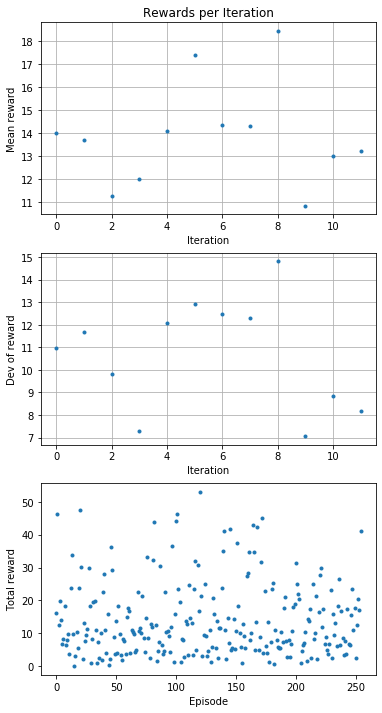

In [42]:
REWARD_THRESHOLD = 100

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

# Analyze the reward distribution for reward function

In [43]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis 91.67999999999999; Max x-axis 938.04
Min y-axis -319.55; Max y-axis 372.28


In [72]:
# add y_offset to bring everything to the positive axis

# this is needed to capture all of your logged y values!!
y_offset = int(df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,1] = inner_border[:,1] + y_offset
center_line[:,1] = center_line[:,1] + y_offset
outer_border[:,1] = outer_border[:,1] + y_offset

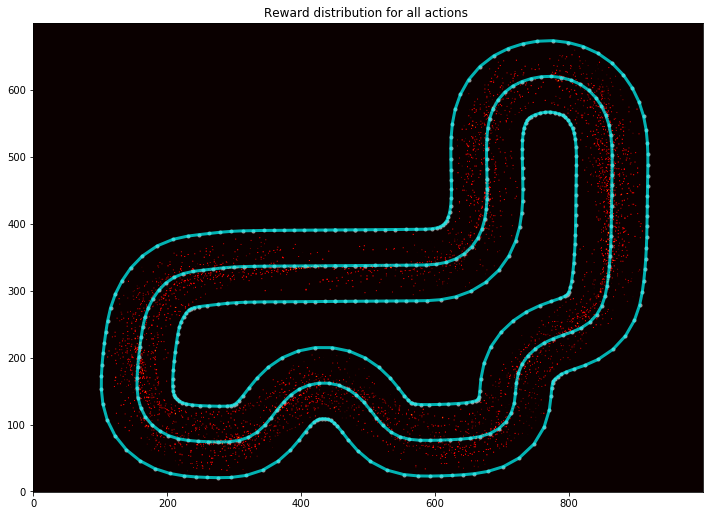

In [149]:
track = plot_track(df, track_size=(700, 1000), x_offset=0, y_offset=y_offset)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

# Plot a particular iteration



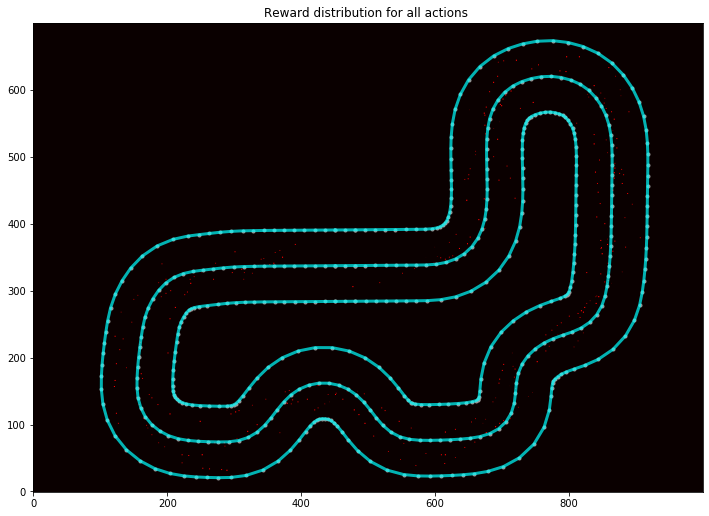

In [151]:
iteration_id = 13
track = plot_track(df[df['iteration'] == iteration_id], track_size=(700, 1000), x_offset=0, y_offset=y_offset)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

In [90]:
# View how number of iterations
df['iteration'].max()

13

# Path Taken for Top Reward Iterations
In single episode, car can go around multiple laps, episode is terminated when car completes 1000 steps

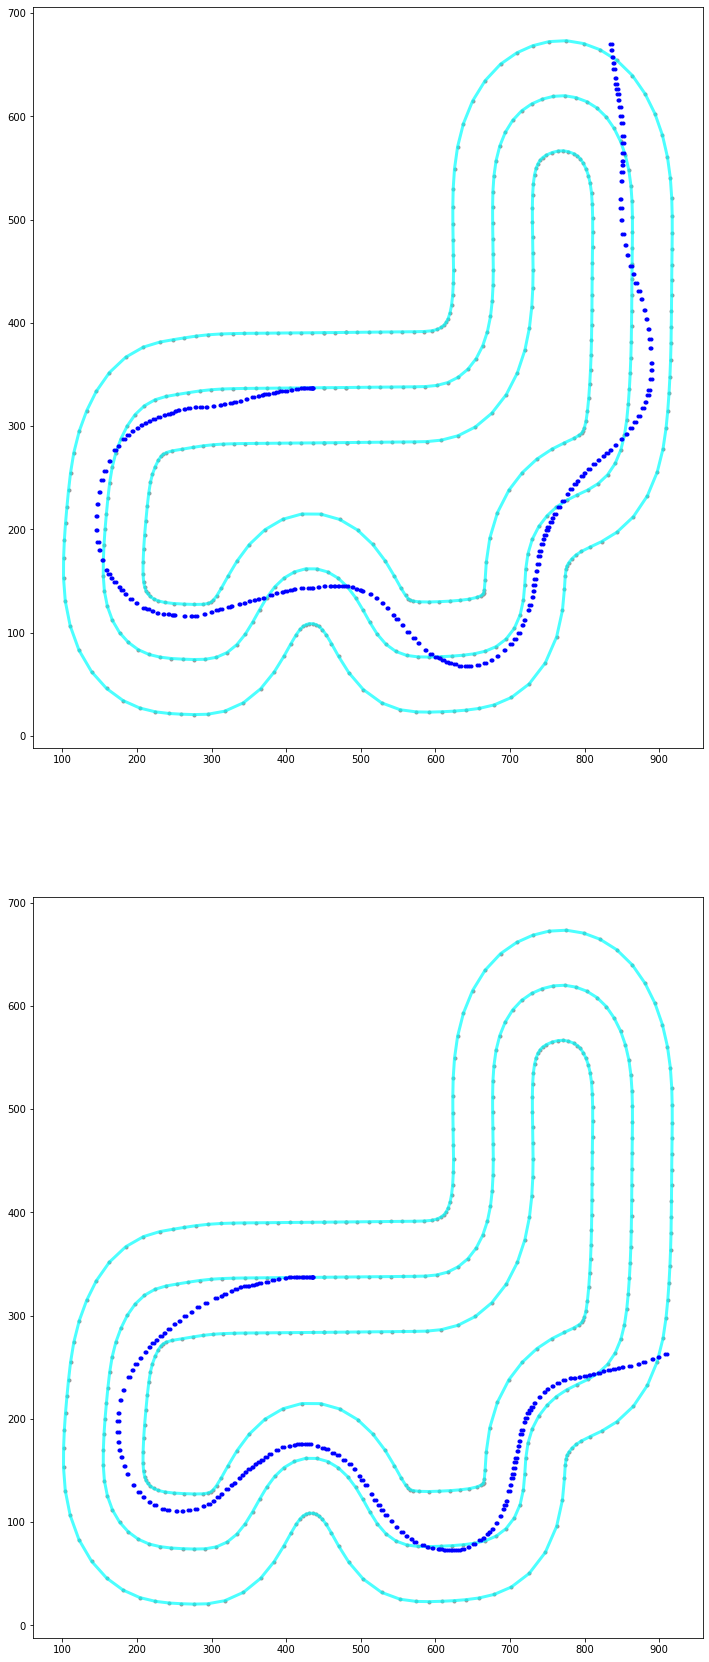

In [192]:
# need to add offset to fix negative values
action_map, episode_map, sorted_idx = episode_parser(data)    
fig = plot_top_laps(sorted_idx[:], 2)

# Path taken in a particular episode

In [179]:
## Evaluation RUN
def plot_episode_run(df, E):
    
    y_offset = int(df['y'].min())
    if y_offset > 0: # if positive, just keep it the same
        y_offset = 0
        y_offset = abs(y_offset)
    
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1 - y_offset, car_y2 - y_offset], 'r.')

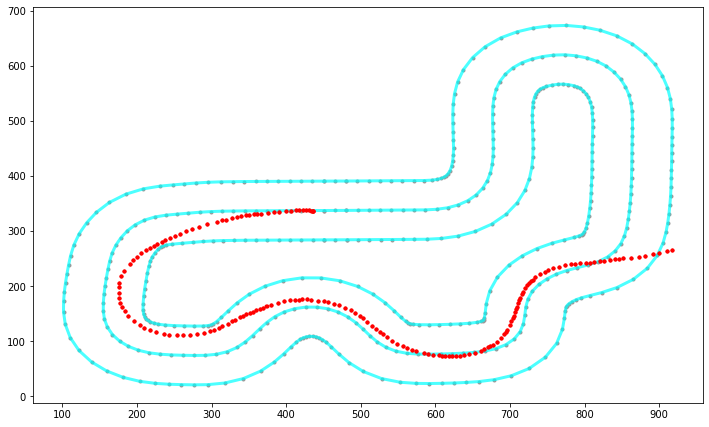

In [180]:
plot_episode_run(df, E=20) # arbitrary episode

# Path taken in a particular Iteration

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


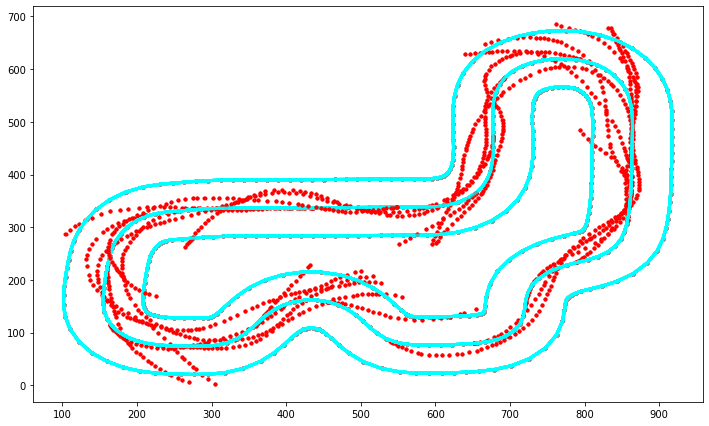

In [193]:
iteration_id = 4

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

** NOTE: This is only supported for reinvent track currently **

Number of steps in iteration= 1271


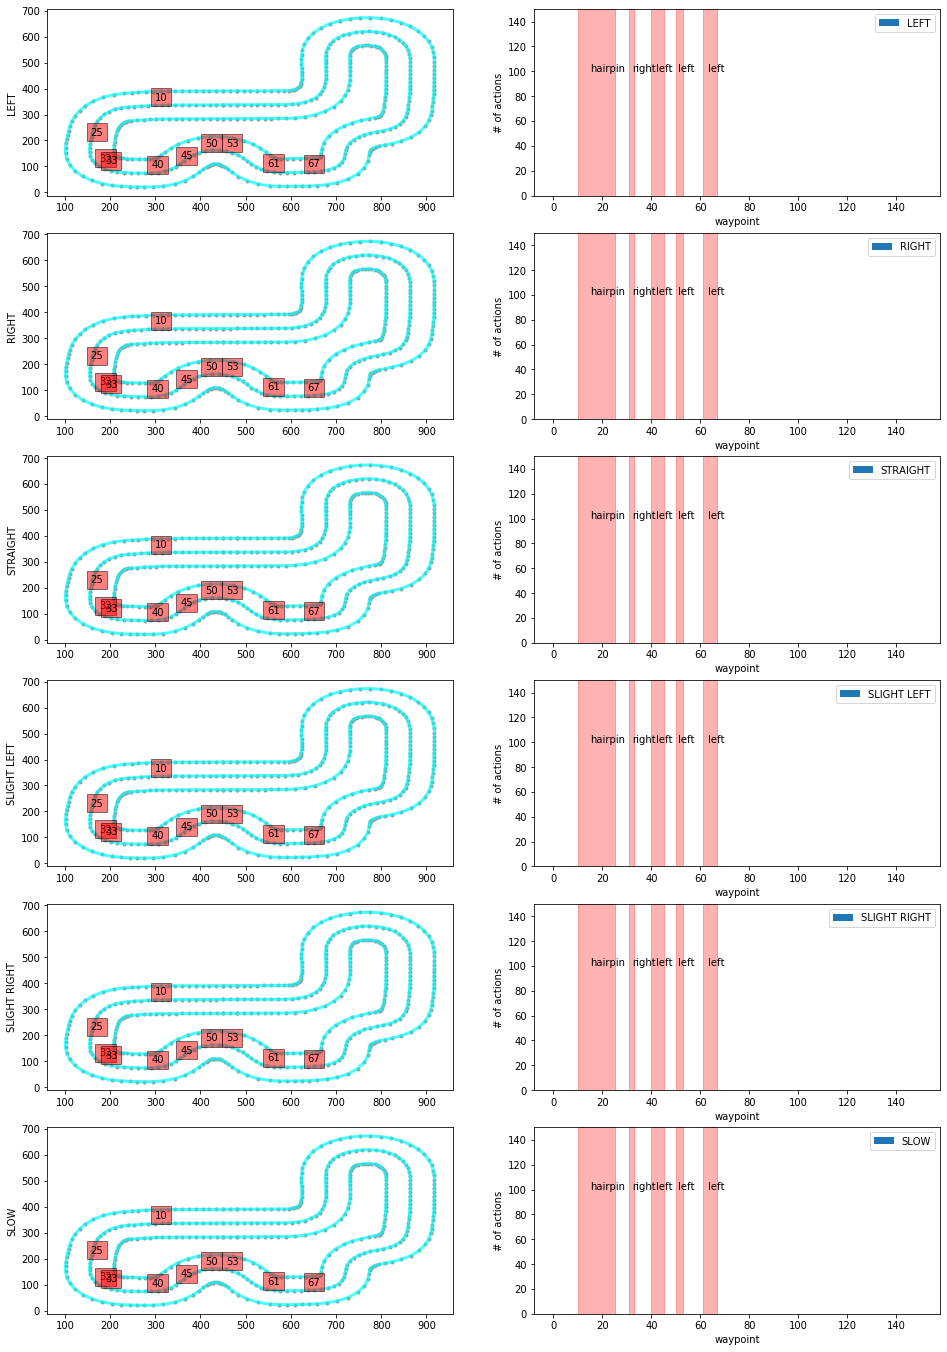

In [195]:
fig = plt.figure(figsize=(16, 24))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

# Track Segment Labels
action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
vert_lines = [10,25,32,33,40,45,50,53,61,67]
track_segments = [(15, 100, 'hairpin'),
                  (32, 100, 'right'),
                  (42, 100, 'left'),
                  (51, 100, 'left'),
                  (63, 100, 'left')]

segment_x = np.array([15, 32, 42, 51, 63])
segment_y = np.array([0, 0, 0, 0, 0])

segment_xerr = np.array([[5, 1, 2, 1, 2], [10, 1, 3, 2, 4]])
segment_yerr = np.array([[0, 0, 0, 0, 0], [150, 150, 150, 150, 150]])

wpts_array = center_line 

for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    th = 0.8
    for idx in range(len(action_names)):
        ax = fig.add_subplot(6, 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in vert_lines:
            ax.text(wpts_array[idWp][0], wpts_array[idWp][1]+20, str(idWp), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(6, 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, 150))

## Evaluation Run Analyis

Debug your evaluation runs or analyze the laps

In [198]:
simulation_name = 'sim-2w3399l9mlmd' 

In [199]:
robomaker = boto3.client('robomaker')
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']
region = boto3.Session().region_name
robomaker_job_arn = "arn:aws:robomaker:{}:{}:simulation-job/{}".format(region, account_id, simulation_name)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(simulation_name)
if os.path.exists(merged_simtrace_path):
    os.remove(merged_simtrace_path)
shutil.rmtree('./tmp') if os.path.exists('./tmp') else os.mkdir('./tmp')

In [200]:
# Get all the infro
job_desc = robomaker.describe_simulation_job(job=robomaker_job_arn)

is_training = job_desc['simulationApplications'][0]['launchConfig']['launchFile'] == "distributed_training.launch"
s3_bucket = job_desc['outputLocation']['s3Bucket']
s3_prefix = job_desc['outputLocation']['s3Prefix']
job_type = "training" if is_training else "evaluation"
simtrace_path = "iteration-data/{}/".format(job_type)

# Downlaod all the simtrace iteration data
!aws s3 sync s3://{s3_bucket}/{s3_prefix}/{simtrace_path} ./tmp --exclude "*" --include "*-{job_type}-simtrace.csv"

KeyError: 'outputLocation'

# Grid World Analysis
Understand the speed of the car along with the path on a per episode basis. This can help you debug portions of the track where the car may not be going fast. Hence giving you hints on how to improve your reward function.